# FASTER R-CNN


In [1]:
# Configuration and dependencies
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
import imutils.paths as path
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import cv2
import os

class DatasetHelper:

    TEST = 'test'
    TRAIN = 'train'
    MOT16_TEST = 'MOT16-03'
    MOT16_TRAIN = 'MOT16-04'
    IMAGE = 'img1'
    BOUNDARY_BOXES = 'det\\det.txt'

    def __init__(self, path: str):
        self.path = path
        self.IMAGE_TEST_PATH = ''
        self.IMAGE_TRAIN_PATH = ''
        self.BOUNDARY_BOXES_TEST_PATH = ''
        self.BOUNDARY_TRAIN_BOXES_PATH = ''

    def configure(self):
        self.IMAGE_TEST_PATH = os.path.join(self.path, self.TEST, self.MOT16_TEST, self.IMAGE)
        self.IMAGE_TRAIN_PATH = os.path.join(self.path, self.TRAIN, self.MOT16_TRAIN, self.IMAGE)
        self.BOUNDARY_BOXES_TEST_PATH = os.path.join(self.path, self.TEST, self.MOT16_TEST, self.BOUNDARY_BOXES)
        self.BOUNDARY_TRAIN_BOXES_PATH = os.path.join(self.path, self.TRAIN, self.MOT16_TRAIN, self.BOUNDARY_BOXES)
        train = np.transpose(self.load_data(self.IMAGE_TRAIN_PATH, self.BOUNDARY_TRAIN_BOXES_PATH, 10))
        test = np.transpose(self.load_data(self.IMAGE_TEST_PATH, self.BOUNDARY_BOXES_TEST_PATH, 30))
        return train, test

    def load_data(self, image_path: str, boxes_path: str, part:int):
        boxes = []
        output = []
        rows = open(boxes_path).read().strip().split('\n')
        for row in rows:
            row = row.split(',')
            frame = int(row[0])
            startX = float(row[2])
            startY = float(row[3])
            endX = startX + float(row[4])
            endY = startY + float(row[5])
            boxes.append([frame, id, startY, startY, endX, endY])
        all_images = [os.path.join(image_path, f) for f in os.listdir(image_path) if os.path.isfile(os.path.join(image_path, f))]
        img_index = 0
        while img_index < len(all_images) / part:
            image = cv2.imread(all_images[img_index])
            (h, w) = image.shape[:2]
            image_boxes = [box for box in boxes if box[0] == img_index + 1] 
            # scale the bounding box coordinates relative to the spatial
            map(lambda x: (x[0], x[1], x[2] / w, x[3] / h, x[4] / w, x[5] / h), image_boxes)
            image = load_img(all_images[img_index], target_size=(244, 244))
            image = img_to_array(image) / 255.0
            for box in image_boxes:
                output.append((image, np.array([box[2], box[3], box[4], box[5]], dtype="float32")))
            img_index += 1
        return np.array(output, dtype=object)

In [2]:
# model path configuration
MODEL_PATH = "detector.h5"
LB_PATH = "lb.pickle"
PLOTS_PATH = "plots"

#base ML params configuration
INIT_LR = 1e-4
NUM_EPOCHS = 20
BATCH_SIZE = 32


In [3]:
#model creation
model = VGG16(weights="imagenet", include_top=False, input_tensor=Input(shape=(244, 244, 3)))
model.trainable = False
flatten = model.output
flatten = Flatten() (flatten)

In [4]:
# constructing new layer head for multi-class object detection
bboxHead = Dense(128, activation="relu") (flatten)
bboxHead = Dense(64, activation="relu") (bboxHead)
bboxHead = Dense(32, activation="relu") (bboxHead)
bboxHead = Dense(4, activation="sigmoid", name="bounding_box") (bboxHead)

softmaxHead = Dense(512, activation="relu") (flatten)
softmaxHead = Dropout(0.5) (softmaxHead)
softmaxHead = Dense(512, activation="relu") (softmaxHead)
softmaxHead = Dropout(0.5) (softmaxHead)
softmaxHead = Dense(1, activation="softmax", name="class_label") (softmaxHead)
model = Model(
	inputs=model.input,
	outputs=bboxHead)
losses = {
    "bounding_box": "mean_squared_error"
}

lossWeights = {
    "bounding_box": 1.0
}
opt = Adam(learning_rate=INIT_LR)
model.compile(loss=losses, optimizer=opt, metrics=["accuracy"], loss_weights=lossWeights)
print(model.summary())

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 244, 244, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 244, 244, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 244, 244, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 122, 122, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 122, 122, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 122, 122, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 61, 61, 128)       0     

In [5]:
#Extract images
helper = DatasetHelper(os.path.join(os.path.abspath(''), os.pardir, "dataset"))
train, test = helper.configure()
print(train.shape)

(2, 3994)


In [11]:
trainImages = np.array([np.asarray(i).astype(np.float16) for i in train[0]]) 
testImages = np.array([np.asarray(i).astype(np.float16) for i in test[0]]) 
trainBoxes = train[1]
testBoxes = test[1]

In [14]:
import tensorflow as tf
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())
!python --version
tf.test.gpu_device_name()

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 7636452204311076641
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 10087235584
locality {
  bus_id: 1
  links {
  }
}
incarnation: 7418447069327257812
physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 3060, pci bus id: 0000:01:00.0, compute capability: 8.6"
]
Python 3.9.12


'/device:GPU:0'

In [12]:
y = np.array([np.asarray(i).astype(np.float32) for i in trainBoxes]) 
testY = np.array([np.asarray(i).astype(np.float32) for i in testBoxes]) 

trainTargets = {
	"class_label": 0,
	"bounding_box": y
}
# construct a second dictionary, this one for our target testing
# outputs
testTargets = {
	"class_label": 0,
	"bounding_box": testY
}

H = model.fit(
    trainImages, y,
    validation_data=(testImages, testY),
    batch_size=BATCH_SIZE,
    epochs=NUM_EPOCHS,
    verbose=1
)

print("saving model")
model.save(MODEL_PATH, save_format="h5")


Epoch 1/20
125/125 [==============================] - 549s 4s/step - loss: 385620.1562 - accuracy: 0.7516 - val_loss: 535363.8125 - val_accuracy: 0.8448
Epoch 2/20
125/125 [==============================] - 526s 4s/step - loss: 385586.1562 - accuracy: 0.7606 - val_loss: 535362.0000 - val_accuracy: 0.8448
Epoch 3/20
125/125 [==============================] - 529s 4s/step - loss: 385585.8438 - accuracy: 0.7606 - val_loss: 535361.5000 - val_accuracy: 0.8448
Epoch 4/20
125/125 [==============================] - 525s 4s/step - loss: 385585.5938 - accuracy: 0.7606 - val_loss: 535361.3125 - val_accuracy: 0.8448
Epoch 5/20
125/125 [==============================] - 528s 4s/step - loss: 385585.4375 - accuracy: 0.7606 - val_loss: 535361.2500 - val_accuracy: 0.8448
Epoch 6/20
125/125 [==============================] - 527s 4s/step - loss: 385585.5000 - accuracy: 0.7606 - val_loss: 535361.2500 - val_accuracy: 0.8448
Epoch 7/20
125/125 [==============================] - 526s 4s/step - loss: 385585.

KeyError: 'val_bounding_box_loss'

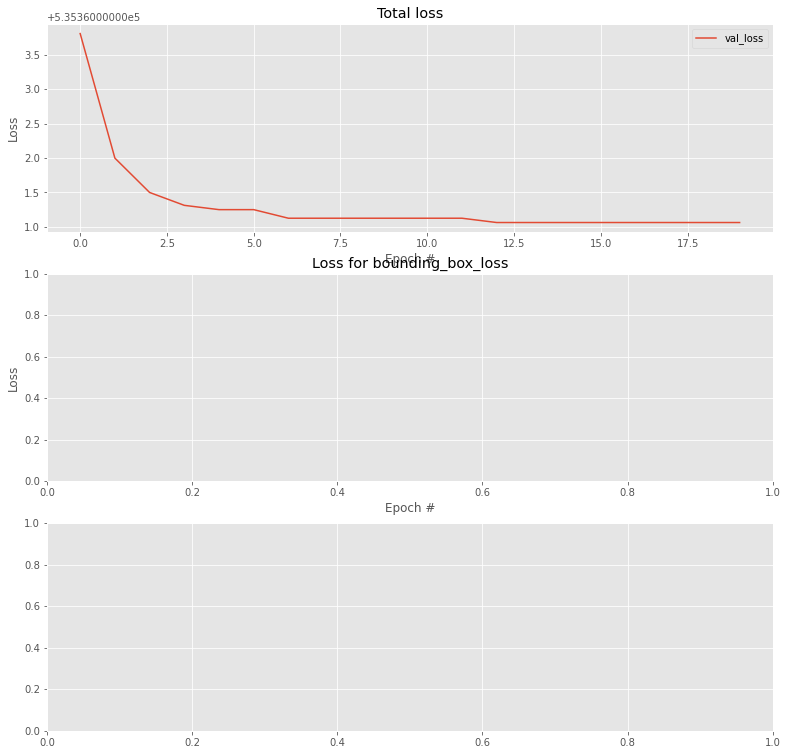

In [24]:
#result visualization
# plot the total loss, label loss, and bounding box loss
lossNames = ["loss", "bounding_box_loss"]
N = np.arange(0, NUM_EPOCHS)
plt.style.use("ggplot")
(fig, ax) = plt.subplots(3, 1, figsize=(13, 13))
# loop over the loss names
for (i, l) in enumerate(lossNames):
	# plot the loss for both the training and validation data
	title = "Loss for {}".format(l) if l != "loss" else "Total loss"
	ax[i].set_title(title)
	ax[i].set_xlabel("Epoch #")
	ax[i].set_ylabel("Loss")
	ax[i].plot(N, H.history["val_" + l], label="val_" + l)
	ax[i].legend()
# save the losses figure and create a new figure for the accuracies
plt.tight_layout()
plotPath = os.path.sep.join([PLOTS_PATH, "losses.png"])
plt.savefig(plotPath)
plt.close()